In [21]:
import sys
import os

sys.path.append(os.path.abspath('../'))

from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import torch.nn as nn
import torch

import dataset
import utils

from tqdm import tqdm
import models
import copy
import time

Sup2Sub = {"aquatic mammals":["beaver", "dolphin", "otter", "seal", "whale"],
"fish":["aquarium_fish", "flatfish", "ray", "shark", "trout"],
"flowers":["orchids", "poppies", "roses", "sunflowers", "tulips"],
"food containers":["bottles", "bowls", "cans", "cups", "plates"],
"fruit and vegetables" : ["apples", "mushrooms", "oranges", "pears", "sweet peppers"],
"household electrical devices":["clock", "computer keyboard", "lamp", "telephone", "television"],
"household furniture":["bed", "chair", "couch", "table", "wardrobe"],
"insects":["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
"large carnivores":["bear", "leopard", "lion", "tiger", "wolf"],
"large man-made outdoor things":["bridge", "castle", "house", "road", "skyscraper"],
"large natural outdoor scenes":["cloud", "forest", "mountain", "plain", "sea"],
"large omnivores_herbivores":["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
"medium-sized mammals":["fox", "porcupine", "possum", "raccoon", "skunk"],
"non-insect invertebrates":["crab", "lobster", "snail", "spider", "worm"],
"people":["baby", "boy", "girl", "man", "woman"],
"reptiles":["crocodile", "dinosaur", "lizard", "snake", "turtle"],
"small mammals":["hamster", "mouse", "rabbit", "shrew", "squirrel"],
"trees":["maple", "oak", "palm", "pine", "willow"],
"vehicles 1":["bicycle", "bus", "motorcycle", "pickup truck", "train"],
"vehicles 2":["lawn-mower", "rocket", "streetcar", "tank", "tractor"]}


Id2Sub = ['apples', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottles', 'bowls',
 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'cans', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cups', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox',
 'girl', 'hamster', 'house', 'kangaroo', 'computer keyboard', 'lamp', 'lawn-mower', 'leopard', 'lion', 'lizard', 'lobster',
 'man', 'maple', 'motorcycle', 'mountain', 'mouse', 'mushrooms', 'oak', 'oranges', 'orchids', 'otter', 'palm', 'pears', 'pickup truck',
 'pine', 'plain', 'plates', 'poppies', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'roses', 'sea', 'seal',
 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflowers', 'sweet peppers', 'table', 'tank',
 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulips', 'turtle', 'wardrobe', 'whale', 'willow','wolf', 'woman', 'worm']


Sup2Id = {}
Id2Sup = {}
idx = 0
for k in Sup2Sub:
    Sup2Id[k] = idx
    Id2Sup[idx] = k
    idx+=1


Sub2Sup = {}
for KK in Sup2Sub.keys():
    for k in Sup2Sub[KK]:
        Sub2Sup[k] = KK
    
SubId2SupId = {}
for k in Sub2Sup:
    SubId2SupId[Id2Sub.index(k)] = Sup2Id[Sub2Sup[k]]
    



In [22]:
from matplotlib import pyplot as plt
from tqdm import tqdm

def preprocessing(data, scale=1):
    if isinstance(data, list):
        data = np.concatenate(data)
    data -= np.min(data)
    data /= np.max(data)
    return data * scale

def normalize(x):
    x = np.array(x)
    x[:, 0] -= np.min(x[:, 0])
    x[:, 0] /= np.max(x[:, 0])

    x[:, 1] -= np.min(x[:, 1])
    x[:, 1] /= np.max(x[:, 1])
    
    return x
    
def get_mean(x):
    return np.mean(x)


def DrawTSNE_superclass(data, label_total, sup_class_num, sub_class_num2=100, fontsize=10, 
                        draw_text = False, size=1, perplexity=30, draw_fig=True):
    
    model=TSNE(n_components=2, perplexity=perplexity)
    data=model.fit_transform(data)
    
    SupLabel = [SubId2SupId[i] for i in label_total]
    
    data = normalize(data)

    sub_class_shlhouette = silhouette_score(data, label_total)
    super_class_shlhouette = silhouette_score(data, SupLabel)

    #  Supper class
    labled_data = [[] for _ in range(sup_class_num)] 

    for i, (x,y) in enumerate(data):
        N = SubId2SupId[label_total[i]]
        labled_data[N].append([x,y])

    labled_data = [np.array(d) for d in labled_data]
    
    Max_Color = 255 * 255 * 255
    basic_color = Max_Color // 25
#     size = 80
    
    super_class_std = []
    for i, d in enumerate(labled_data):
        color=f'#{hex(basic_color * i)[2:].zfill(6)}'
        super_class_std.append([np.std(d[:,0]), np.std(d[:,1])])
        if draw_fig:
            plt.scatter(d[:, 0], d[:, 1], s=size, label = Id2Sup[i], color=color)
            if draw_text:
                plt.text(np.mean(np.sort(d[:,0])),np.mean(np.sort(d[:,1])),s = str(i), color=color,weight =1, fontsize=fontsize)
                plt.text(np.mean(np.sort(d[:,0])),np.mean(np.sort(d[:,1])),s = str(i), color="black",weight =1000, fontsize=fontsize, bbox=dict(fill=False,boxstyle='square',pad=0.01,alpha=1.0, edgecolor= color))

    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    if draw_fig:
        plt.show()
    
    Max_Color = 255 * 255 * 255
    basic_color = Max_Color // 101

    #  Sub class
    labled_data = [[] for _ in range(sub_class_num2)] 

    for i, (x,y) in enumerate(data):
        labled_data[label_total[i]].append([x,y])

    labled_data = [np.array(d) for d in labled_data]
        
    sub_class_std = []
    if draw_fig:
        for i, d in enumerate(labled_data):
            color=f'#{hex(basic_color * i)[2:].zfill(6)}'
            sub_class_std.append([np.std(d[:,0]), np.std(d[:,1])])
            if draw_fig:
                plt.scatter(d[:, 0], d[:, 1], s=size, label = str(i), color=color)
                if draw_text:
                    plt.text(np.mean(np.sort(d[:,0])),np.mean(np.sort(d[:,1])),s = str(i), color=color,weight =1, fontsize=fontsize)
                    plt.text(np.mean(np.sort(d[:,0])),np.mean(np.sort(d[:,1])),s = str(i), color="black",weight =1000, fontsize=fontsize, bbox=dict(fill=False,boxstyle='square',pad=0.01,alpha=1.0, edgecolor= color))
    
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    if draw_fig:
        plt.show()

    return super_class_std, sub_class_std, super_class_shlhouette, sub_class_shlhouette

In [30]:
def get_total_output(data_loader, teacher, baseline, lrp_gamma = 1.2, device='cuda', draw_fig=True):
    gi_total = []
    label_total = []
    correct_org, correct_gi = 0, 0
    
    teacher = teacher.to(device)
    baseline = baseline.to(device)
    
    refiner = utils.Refiner(teacher=teacher, lrp_gamma=lrp_gamma)

    teacher.eval()
    baseline.eval()
    softmax = nn.Softmax(dim=1)
    use_softmax = False
    time.sleep(1)

    with tqdm(data_loader, unit='batch') as pbar:
        for batch, (img, label) in enumerate(pbar):
            img = img.to(device)
            label = label.to(device)

            refined_data = refiner.get_refined_image(img, label)
            img.grad = None

            with torch.no_grad():
                if use_softmax:
                    output_gi = softmax(teacher(refined_data)) # use lrp image
                    output_org = softmax(baseline(img))  # vanilla


                else:
                    output_gi = teacher(refined_data) # use lrp image
                    output_org = teacher(img)  # vanilla


            correct_org += sum(label == torch.argmax(output_org, dim=1)).item()
            correct_gi += sum(label == torch.argmax(output_gi, dim=1)).item()

            output_org = output_org.cpu().detach().numpy()
            output_gi = output_gi.cpu().detach().numpy()

            label_total += label.tolist()
            gi_total.append(output_gi)

            pbar.set_postfix(org = correct_org / len(label_total), gi = correct_gi / len(label_total))
#             if batch > 10:
#                 break
            
    gi_total = preprocessing(gi_total)
    print(f"mult : {mult}")
    gi_super_std, gi_sub_std, gi_super_shlh, gi_sub_shlh =  DrawTSNE_superclass(gi_total, label_total, len(Sup2Sub), draw_text=False, draw_fig=True)
    print("gi_super_shlh : ", gi_super_shlh)
    print("gi_sub_shlh : ", gi_sub_shlh)


    return gi_super_std, gi_sub_std, gi_super_shlh, gi_sub_shlh

In [24]:
= nn.MSELoss().cuda()
criterion_L1 = lambda a,b: torch.sum(a-b)/len(a)
criterion_CE = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), 

100%|████████████████████████████████████████████████████████| 782/782 [00:31<00:00, 24.70batch/s, gi=0.859, org=0.859]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


mult : 0.0


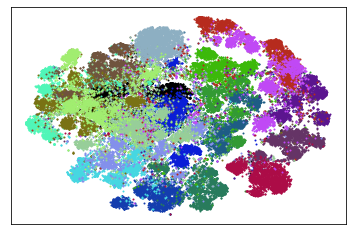

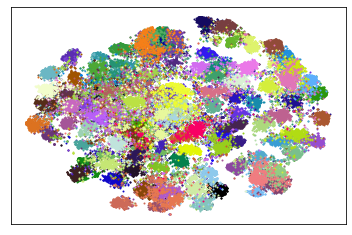

0.09883493 0.049267955
ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2

100%|████████████████████████████████████████████████████████| 782/782 [00:29<00:00, 26.81batch/s, gi=0.935, org=0.858]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


mult : 0.5


KeyboardInterrupt: 

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

train_loader, test_loader, num_classes, _ = dataset.create_loader(64, "./data/", "CIFAR100")


font = "Times new roman cyr"
plt.rcParams['font.family']=font
model_name = 'resnet20'
teacher = models.__dict__['resnet20'](num_classes=num_classes)
teacher.load_state_dict(torch.load(f"../teacher_models/CIFAR100/resnet20/model.pth"))
baseline = copy.deepcopy(teacher)

teacher.eval()
baseline.eval()

device = torch.device('cuda')

mult = 1.0

super_stds20 = []
sub_stds20 = []
gi_super_shlhs20, gi_sub_shlhs20 = [], []

for mult in [0.0, 0.5, 1.0, 2.0]:
    gi_super_std, gi_sub_std, gi_super_shlh, gi_sub_shlh  =  get_total_output(train_loader, teacher, baseline, mult)
    print(gi_super_shlh, gi_sub_shlh)
    
    gi_super_shlhs20.append(gi_super_shlh)
    gi_sub_shlhs20.append(gi_sub_shlh)
    super_stds20.append(get_mean(gi_super_std))
    sub_stds20.append(get_mean(gi_sub_std))
    